<a href="https://colab.research.google.com/github/jonnunez92/Datasets-for-Modeling/blob/main/Healthcare_Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Healthcare Stroke Prediction**

Jonathan Nunez

# Load Data and Libraries


In [69]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

## Models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression

## Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_original = pd.read_csv('/content/drive/MyDrive/Data Sets for Coding Dojo/healthcare-dataset-stroke-data.csv')
df = df_original.copy()
df.head()     

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Dictionary

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

# Clean Data

## Data types and Info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
# object datatypes
df.dtypes[df.dtypes == 'object']

gender            object
ever_married      object
work_type         object
Residence_type    object
smoking_status    object
dtype: object

In [6]:
# number datatypes
df.dtypes[df.dtypes != 'object']

id                     int64
age                  float64
hypertension           int64
heart_disease          int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
dtype: object

## Duplicates

In [7]:
df.duplicated().sum()

0

## Inconsistencies in 'object' Categories

In [8]:
for i in df.dtypes[df.dtypes == 'object'].index:
  print(f'{i} ---')
  print(df[i].value_counts())
  print('')

gender ---
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

ever_married ---
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type ---
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type ---
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

smoking_status ---
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



- Only 1 'Other' in 'gender' column

### 'smoking_status' replace 'Unknown' with NaN

- 'smoking_status' shows 'Unknown' which means the information is unavailable
  - Will replace 'Unknown' with NaN to show that this info is missing

In [9]:
df['smoking_status'] = df['smoking_status'].replace('Unknown', np.nan)

for i in df.dtypes[df.dtypes == 'object'].index:
  print(f'{i} ---')
  print(df[i].unique())
  print('')

gender ---
['Male' 'Female' 'Other']

ever_married ---
['Yes' 'No']

work_type ---
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Residence_type ---
['Urban' 'Rural']

smoking_status ---
['formerly smoked' 'never smoked' 'smokes' nan]



## Inconsistencies in 'number' Categories

In [10]:
df.describe(include='number')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- 'age' shows **min** age of *0.08*
- 'bmi' shows **max** bmi of *97.6*
- Notable values that I'll keep in mind

### Investigate Notable Values

In [11]:
# age of 0.08
df[df['age'] == 0.08]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,NaN,0
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,NaN,0


- Only 2 samples, correctly attributed as 'children'

In [12]:
# bmi of 97.6
df[df['bmi'] == 97.6]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,NaN,0


- Only 1 sample, 17 year old male with hypertension, but no heart disease

## Missing Data

In [13]:
df.isna().sum()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

In [14]:
# missing values as percentage
round((df.isna().sum() / len(df)) * 100, 2)

id                    0.00
gender                0.00
age                   0.00
hypertension          0.00
heart_disease         0.00
ever_married          0.00
work_type             0.00
Residence_type        0.00
avg_glucose_level     0.00
bmi                   3.93
smoking_status       30.22
stroke                0.00
dtype: float64

- **Missing values will be imputed in the Machine Learning stage**

## Remove Unnecessary/ Irrelevant Columns

### Drop 'id'
- Too unique and not necessary for predicting strokes

In [15]:
df.drop(columns='id', inplace=True)

In [16]:
df.head(1)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1


# Exploratory Visualizations

## Heatmap of Stroke Correlation

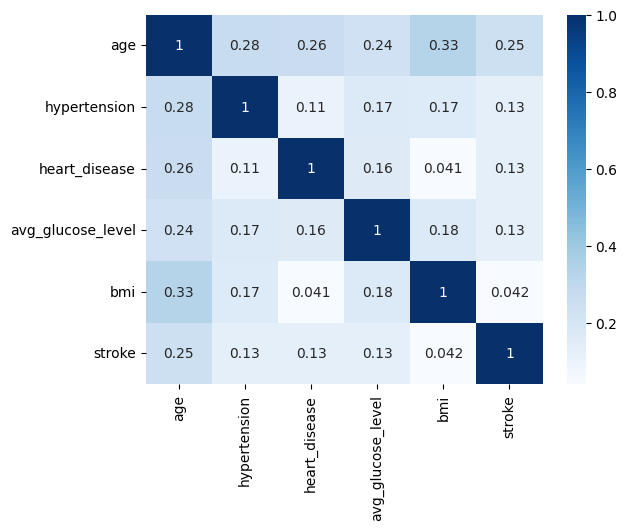

In [70]:
corr = df.corr()
sns.heatmap(data=corr, cmap='Blues', annot=True);

- Looks like the most correlated feature with 'stroke is 'age'
- Suprisingly, 'bmi' is not strongly correlated with stroke

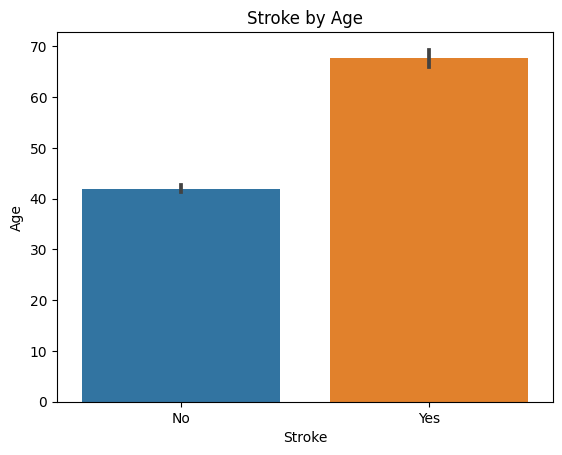

In [34]:
fig, ax = plt.subplots()

sns.barplot(data=df, x='stroke', y='age')
ax.set_title('Stroke by Age')
ax.set_xlabel('Stroke')
ax.set_ylabel('Age')
plt.xticks(range(0,2), ['No', 'Yes']);

- People that get strokes are, on average, older; around 65-70 years old
- People that don't get strokes are, on average, younger at around 40 years old

## Count of Smoking Status with Stroke Count

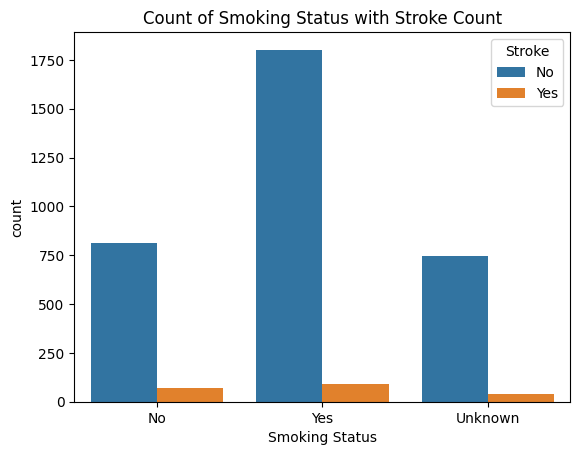

In [35]:
fig, ax = plt.subplots()

ax = sns.countplot(data=df, x='smoking_status', hue='stroke')
ax.set_title('Count of Smoking Status with Stroke Count')
ax.set_xlabel('Smoking Status')
plt.xticks(range(0,3),['No', 'Yes', 'Unknown'])
plt.legend(title='Stroke', labels=['No', 'Yes']);

- There are much more people that *don't* have strokes
- We can see that there are a significant amount of smokers
  - That being said, their rate of stroke is about the same as non-smokers

## Count of Gender with Stroke Count

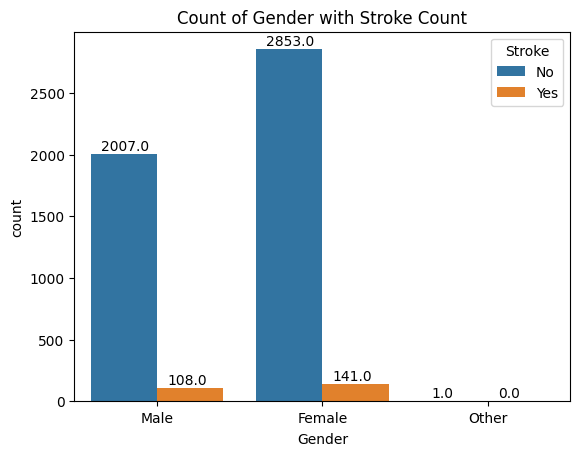

In [68]:
fig, ax = plt.subplots()

ax = sns.countplot(data=df, x='gender', hue='stroke')

ax.set_title('Count of Gender with Stroke Count')
ax.set_xlabel('Gender')
plt.legend(title='Stroke', labels=['No', 'Yes'])
ax.xaxis.labelpad = 5

# code beneath was found on StackOverflow
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.06, p.get_height()+30));

- We can see that there are more females represented in this dataset
- More females *don't* have strokes, but at the same time, more females *do* have strokes

## Distribution of Age and BMI

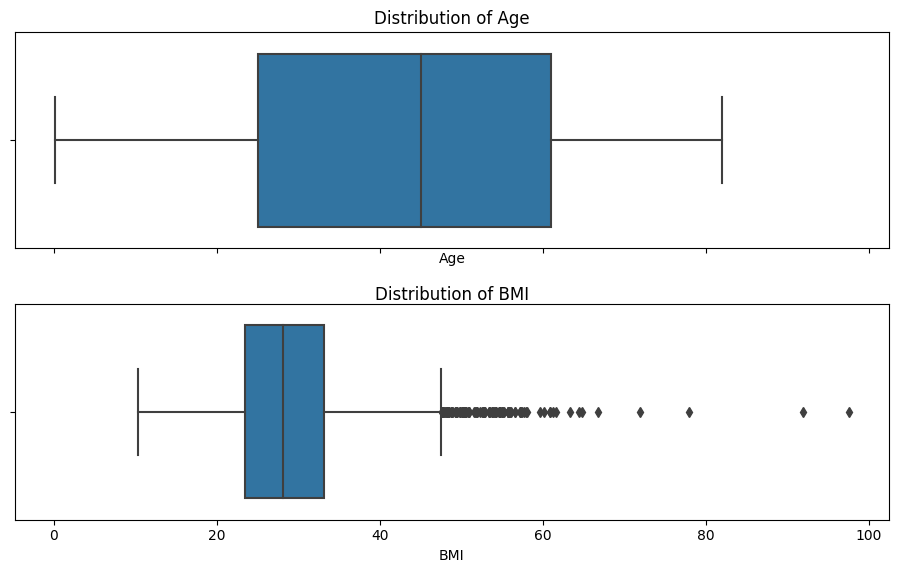

In [67]:
fig, axes = plt.subplots(nrows=2, figsize=(10,6), sharex=True)
fig.tight_layout(pad=3)

sns.boxplot(data=df, x='age', ax=axes[0])
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age')
axes[0].xaxis.labelpad = -1

sns.boxplot(data=df, x='bmi', ax=axes[1])
axes[1].set_title('Distribution of BMI', pad=2)
axes[1].set_xlabel('BMI');

- Both of these are continuous measurements and have similar scales, so they can be paired
- Median age is around 45
- Median BMI is around 30
- BMI has a lot of outliers

## Distribution of Average Glucose Level

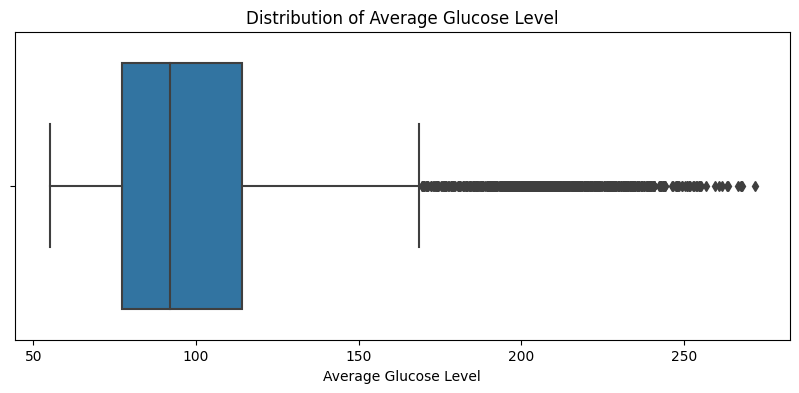

In [65]:
fig, ax = plt.subplots(figsize=(10,4))

sns.boxplot(data=df, x='avg_glucose_level')
ax.set_title('Distribution of Average Glucose Level')
ax.set_xlabel('Average Glucose Level');

- Median glucose level is around 90
- There are a significant amount of outliers